In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import zarr
import os

matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.pyplot.rcParams.update({
    "pgf.preamble": [
         "\\usepackage{arev}",""
        "\\usepackage[T1]{fontenc}"]
})

device='cpu'

# top-down likelihood

In [2]:
# import classifier and prior sampler
from rad_utils import select_model
from models import NoisyImageClassifierWithTimeEmbedding, NoiseConditionalEstimatorConcat
from utils import load_model_weights, load_model_description

# 15 for intersected, 6 for separate manifolds
diffuser_details = load_model_description('unconditional-concat', 6)
diffuser_model_name = diffuser_details['model_name']
diffuser_model_num = diffuser_details['model_number']
num_steps = diffuser_details['num_steps']
num_hidden_diffuser = diffuser_details['num_hidden']
prior_sampler = NoiseConditionalEstimatorConcat(num_hidden_diffuser)

# 2 for separated, 3 for intersected manifolds
classifier_details = load_model_description('noisy-image-classifier-with-noise-info', 2)
classifier_model_name = classifier_details['model_name']
classifier_model_num = classifier_details['model_number']
num_in = classifier_details['num_in']
num_hidden_classifier = classifier_details['num_hidden']
num_classes = classifier_details['num_classes']
num_steps_classifier = classifier_details['num_steps']
classifier = NoisyImageClassifierWithTimeEmbedding(num_in, num_hidden_classifier, num_classes, num_steps_classifier)

prior_sampler = load_model_weights(prior_sampler, diffuser_model_name, diffuser_model_num, device)
classifier = load_model_weights(classifier, classifier_model_name, classifier_model_num, device)

prior_sampler.eval()
classifier.eval()

model loaded!
model loaded!


NoisyImageClassifierWithTimeEmbedding(
  (linear1): Linear(in_features=2, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=3, bias=True)
  (nonlin): ReLU()
  (softmax): Softmax(dim=1)
  (embed): Embedding(100, 20)
)

torch.Size([101, 10000, 2])


[(-1.5, 1.5), (-1.5, 1.5), None]

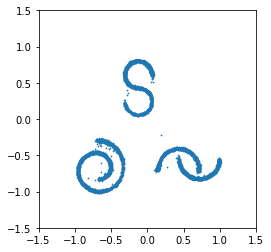

In [3]:
# show the effect of the prior sampler
from utils import forward_process
from generate_data import p_sample_loop

num_samples = int(1e4)
betas, alphas, _, _, _, _, one_minus_alphas_prod_sqrt = forward_process(num_steps, device)
x_seq = p_sample_loop(prior_sampler, (num_samples,2), num_steps, alphas, betas, one_minus_alphas_prod_sqrt, device)
x_seq = torch.stack(x_seq).detach()

print(x_seq.shape)

fig, ax = plt.subplots(1, 1)
ax.scatter(*x_seq[-1].T, s=0.5)
ax.set(xlim=[-1.5,1.5], ylim=[-1.5, 1.5], aspect='equal')


size of the training set is 3000


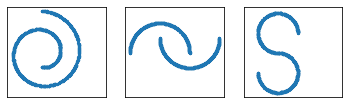

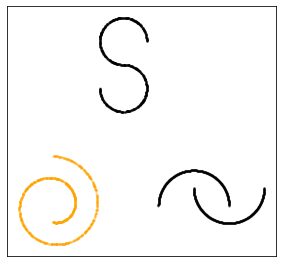

In [4]:
# load the dataset
from generate_data import load_trimodal_data, load_unimodal_data
sample_size = int(1e3)

# offsets = [[0,0], [1,0], [1,1]]
offsets = [[0,0], [4,0], [2,4]]
# offsets = [[0.5,0.5], [0,1.5], [2,1]]
dataset = load_trimodal_data(sample_size, offsets, train_test_split=False, noise=0, plot=True)

yellow


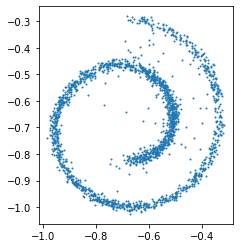

In [5]:
from likelihood_utils import perform_top_down_inference
x_seq, label = perform_top_down_inference(prior_sampler, classifier, label=0, s=0.1, sample_size=2e3, num_steps=100, device='cpu')
fig, ax = plt.subplots(1, 1)
ax.scatter(*x_seq[-1].T, s=1)
ax.set_aspect('equal')
# print(x_seq[25])

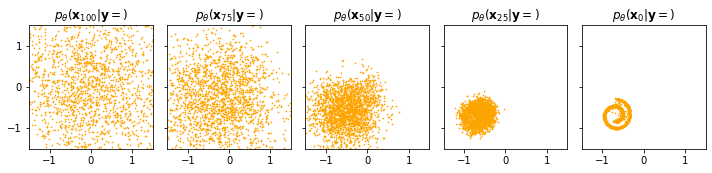

In [6]:
lims = [-1.5, 1.5]
fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True)

for i in range(0, 5):
    cur_x = x_seq[i * 25]
    ax = axes[i]
    ax.scatter(*cur_x.T, edgecolor='orange', s=0.5);
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims)
    ax.set_title('$p_{\\theta}(\mathbf{x}_{'+str(num_steps - i*25)+'} | \mathbf{y}={})$')

fig.tight_layout()
axes[0].set_yticks([-1, 0, 1])

# combining top-down and bottom-up likelihoods

In [112]:
# import bottom-up likelihood
# from likelihood_utils import calc_bottom_up_likelihood
from likelihood_utils import perform_variable_inference

# v = np.array([[3.5, 5]]).T
v = np.array([[2, -5]]).T
label = 2
constraint_sigma = 0.035
s_bu = 0.015
s_td = 0.2
n_steps = 100
sample_size = 2e2
mode = 'bottom-up'  # 'top-down' or 'bottom-up' or 'both' or 'neither'

x_seq, label = perform_variable_inference(prior_sampler, classifier, v, mode, label, constraint_sigma, s_bu, s_td, n_steps, sample_size, device)




yellow
bottom-up mode
not yellow
not yellow


label 2


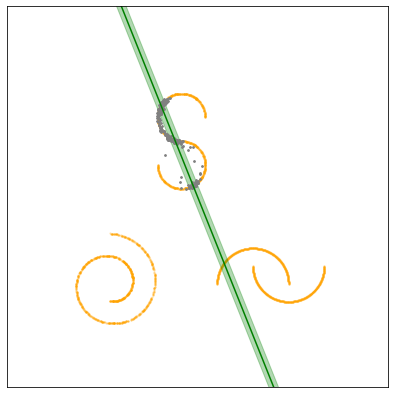

In [121]:
from rad_utils import remove_all_ticks_and_labels

# x_seq = torch.load('saved_arrays/samples_only_BU_llh.pt')
# x_seq = torch.load('saved_arrays/samples_only_TD_llh.pt')
x_seq = torch.load('saved_arrays/samples_both_TD_and_BU_llhs.pt')
# x_seq = torch.load('saved_arrays/samples_neither_TD_and_BU_llhs.pt')

# print(x_seq[-1].shape)
print('label', label)
# print(dataset.shape)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.set_aspect('equal')
ax.set(xlim=lims, ylim=lims)
ls = np.linspace(-1.5, 1.5, 100)
a = remove_all_ticks_and_labels(ax)

# manifold
ax.scatter(*dataset[:, :2].T, s=2, alpha=0.2, c='orange')

# constraint line
ax.plot(ls * v[0], ls * v[1], c='green', label='constraint')
below = ls * v[1] - constraint_sigma / np.cos(np.arctan(v[1]/v[0]))
above = ls * v[1] + constraint_sigma / np.cos(np.arctan(v[1]/v[0]))
ax.fill_between(ls * v[0], below, above, color='green', alpha=0.3)

# data
ax.scatter(*x_seq[-1].T, color='grey', s=3)



save=True

# save plot
if save==True:
    savedir = 'plots/neurips'
    figname = f'posterior-samples-both-TD-and-BU.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

# save the samples
from likelihood_utils import save_or_load_to_pt
# if save:
#     save_or_load_to_pt('save', 'samples_only_BU_llh', data=x_seq)


# score fields

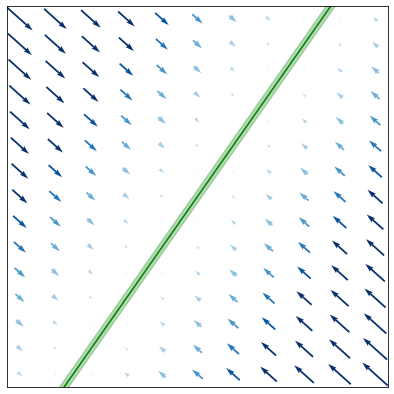

In [19]:
lim = 1.5
lims = [-lim, lim]
score_lim = lim - 0.1

x_hyps = []
for i in np.linspace(-score_lim, score_lim, 11):
    x_hyp = np.linspace(start=[-i, score_lim], stop=[-i, -score_lim], num=15)
    x_hyps.append(x_hyp)
x_hyps = np.vstack(x_hyps)
x_hyps = torch.tensor(x_hyps, dtype=torch.float)

v = np.array([[3.5, 5]]).T
M = v / np.linalg.norm(v)
Mm = M @ M.T
Mm = torch.from_numpy(Mm).float()

from likelihood_utils import compute_occlusion_score
scores = compute_occlusion_score(x_hyps, Mm)
scores = scores/torch.norm(scores, dim=0)**0.7

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
# fig.suptitle('score of likelihood model evaluated at many test points in Z\n $\\nabla_z \log p(M^T z|z)$')
ax.set(xlim=lims, ylim=lims)

ax.plot(ls * v[0], ls * v[1], c='green', label='constraint')
# instead of linewidth, use fill_between
below = ls * v[1] - constraint_sigma / np.cos(np.arctan(v[1]/v[0]))
above = ls * v[1] + constraint_sigma / np.cos(np.arctan(v[1]/v[0]))
ax.fill_between(ls * v[0], below, above, color='green', alpha=0.3)

color = np.hypot(scores[:, 0], scores[:, 1])**2

ax.quiver(*x_hyps.T, *scores.T,
            color,
            cmap="Blues",
            angles = 'xy',
            scale_units = 'width',
            scale = 5,
            pivot = 'mid',
            clim=(-.02, 0.07)
            )
ax.set_aspect('equal')
# ax.legend(loc='upper right')
remove_all_ticks_and_labels(ax)



save=False
if save==True:
    savedir = 'plots/neurips'
    figname = f'flow-field-continuous-likelihood-trimodal.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

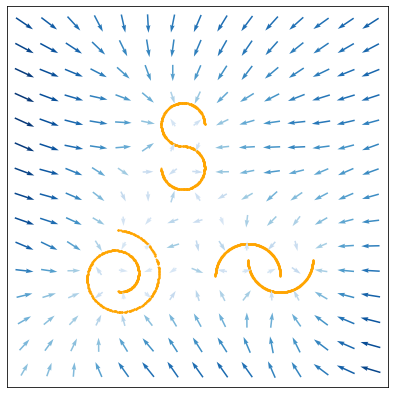

In [21]:
from likelihood_utils import compute_diffuser_score

# display the flow field for the prior sampler 
lim = 1.5
num_samples = 15

t = torch.tensor([0])

score_xs = []
score_ys = []
for sample_y in np.linspace(-lim, lim, num_samples):
    for sample_x in np.linspace(-lim, lim, num_samples):
        
        # compute the score 
        x = torch.tensor([[sample_x, sample_y]], dtype=torch.float)
        diffuser_score = compute_diffuser_score(prior_sampler, x, t=t).detach()
        
        # rescales vectors so you don't have such a huge difference between the largest and smallest
        diffuser_score = diffuser_score/torch.norm(diffuser_score, dim=1)**0.7
        
        score_x, score_y = -diffuser_score[0,0], -diffuser_score[0,1]
        
        # collect data
        score_xs.append(score_x)
        score_ys.append(score_y)
score_xs = torch.stack(score_xs).reshape(num_samples, num_samples)
score_ys = torch.stack(score_ys).reshape(num_samples, num_samples)

color = np.hypot(score_xs, score_ys)**2

# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(*dataset[:, :2].T, s=1, alpha=0.8, c='orange')
q = ax.quiver(np.linspace(-lim, lim, num_samples), np.linspace(-lim, lim, num_samples), 
          score_xs, score_ys, 
          color,
          cmap='Blues',
          angles='xy', scale_units='xy', pivot='mid',
          scale=15,
          clim=(0, 8))
# plt.clim(0,120)
ax.set_aspect('equal')
from rad_utils import remove_all_ticks_and_labels
remove_all_ticks_and_labels(ax)

save=False
if save==True:
    savedir = 'plots/neurips'
    figname = f'flow-field-trimodal-prior.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

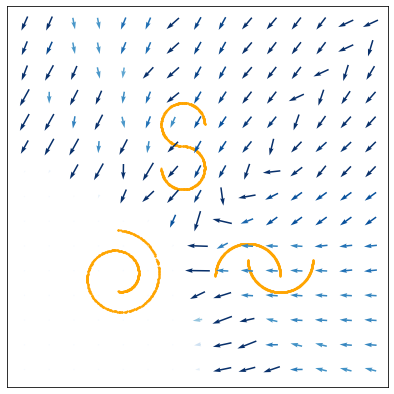

In [29]:
from likelihood_utils import compute_classifier_score
# display the flow field for the prior sampler 
lim = 1.5
num_samples = 15
label = 0

t = torch.tensor([9])

score_xs = []
score_ys = []
for sample_y in np.linspace(-lim, lim, num_samples):
    for sample_x in np.linspace(-lim, lim, num_samples):
        
        # compute the score 
        x = torch.tensor([[sample_x, sample_y]], dtype=torch.float)
        classifier_score = compute_classifier_score(classifier, x, class_label=label, t=t)
        
        # rescales vectors so you don't have such a huge difference between the largest and smallest
        classifier_score = classifier_score/torch.norm(classifier_score, dim=1)**0.5
        
        score_x, score_y = classifier_score[0,0], classifier_score[0,1]
        
        # collect data
        score_xs.append(score_x)
        score_ys.append(score_y)
score_xs = torch.stack(score_xs).reshape(num_samples, num_samples)
score_ys = torch.stack(score_ys).reshape(num_samples, num_samples)

color = np.hypot(score_xs, score_ys)**2

# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(*dataset[:, :2].T, s=1, alpha=0.8, c='orange')
ax.quiver(np.linspace(-lim, lim, num_samples), np.linspace(-lim, lim, num_samples),
          score_xs, score_ys, 
          color,
          cmap='Blues',
          angles='xy', scale_units='xy', pivot='mid',
          scale=35,
          clim=(0, 21)
          )
ax.set_aspect('equal')
from rad_utils import remove_all_ticks_and_labels
remove_all_ticks_and_labels(ax)

save=True
if save==True:
    savedir = 'plots/neurips'
    figname = f'flow-field-trimodal-classifier.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

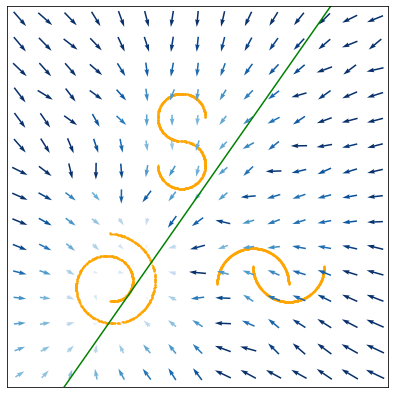

In [30]:
# ----------------------------- joint flow field ----------------------------- #
from likelihood_utils import compute_classifier_score
# display the flow field for the prior sampler 
lim = 1.5
num_samples = 15
label = 0

score_lim = lim - 0.1
lims = [-lim, lim]

v = np.array([[3.5, 5]]).T
M = v / np.linalg.norm(v)
Mm = M @ M.T
Mm = torch.from_numpy(Mm).float()


t = torch.tensor([9])

score_xs = []
score_ys = []
for sample_y in np.linspace(-score_lim, score_lim, num_samples):
    for sample_x in np.linspace(-score_lim, score_lim, num_samples):
        
        # compute the score 
        x = torch.tensor([[sample_x, sample_y]], dtype=torch.float)
        
        diffuser_score = compute_diffuser_score(prior_sampler, x, t=t).detach()
        
        classifier_score = compute_classifier_score(classifier, x, class_label=label, t=t)
        
        sensory_score = compute_occlusion_score(x, Mm)
        
        posterior_score = -2*diffuser_score + 1.2*classifier_score + 23*sensory_score
        
        # rescales vectors so you don't have such a huge difference between the largest and smallest
        posterior_score = posterior_score/torch.norm(posterior_score, dim=1)**0.6
        
        score_x, score_y = posterior_score[0,0], posterior_score[0,1]
        
        # collect data
        score_xs.append(score_x)
        score_ys.append(score_y)
score_xs = torch.stack(score_xs).reshape(num_samples, num_samples)
score_ys = torch.stack(score_ys).reshape(num_samples, num_samples)

color = np.hypot(score_xs, score_ys)**2

# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(*dataset[:, :2].T, s=1, alpha=0.8, c='orange')
ax.plot(ls * v[0], ls * v[1], c='green', label='constraint')
ax.quiver(np.linspace(-score_lim, score_lim, num_samples), np.linspace(-score_lim, score_lim, num_samples), 
          score_xs, score_ys, 
          color,
          cmap='Blues',
          angles='xy', scale_units='xy', pivot='mid',
          scale=40,
          clim=(0, 25)
          )
ax.set_aspect('equal')
ax.set(xlim=lims, ylim=lims)
from rad_utils import remove_all_ticks_and_labels
remove_all_ticks_and_labels(ax)

save=True
if save==True:
    savedir = 'plots/neurips'
    figname = f'flow-field-posterior-trimodal.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)
